In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Tang Band W3-1876S Parameters - Updated from impedance measurements
subwoofer_params = {
    'name': 'Tang Band W3-1876S',
    'type': '3" Full-Range/Subwoofer',
    'quantity': 2,  # Dual drivers
    'impedance': 4,  # Ω (each driver)
    'impedance_parallel': 2,  # Ω (both in parallel)
    'sensitivity': 84,  # dB @ 2.83V/1m (single driver - measured)
    'sensitivity_dual': 90,  # dB @ 2.83V/1m (dual drivers +6dB)
    'fs': 55,  # Hz - Will be updated from impedance measurement
    'qts': 0.46,  # Total Q factor (ESTIMATED from impedance curve)
    'qms': 4.87,  # Mechanical Q factor (ESTIMATED)
    'qes': 0.51,  # Electrical Q factor (ESTIMATED)
    'vas': 1.4,  # L - Equivalent volume (UPDATED)
    'bl': 2.9,  # Tm - BL product (ESTIMATED)
    're': 3.0,  # Ω - DC resistance (FROM IMPEDANCE)
    'sd': 25e-4,  # m² - Effective piston area (25 cm²)
    'xmax': 5e-3,  # m - Maximum linear excursion 
    'mms': 4.2e-3,  # kg - Moving mass (4.2g - ESTIMATED)
    'cms': 1380e-6,  # m/N - Compliance (CALCULATED from Fs)
    'diameter': 93.2e-3,  # m - Overall outside diameter
    'cutout_diameter': 74.4e-3,  # m - Baffle cutout diameter
    'depth': 65.8e-3,  # m - Overall depth
    'power_rms': 20,  # W - RMS power handling (CONSERVATIVE)
    'power_max': 40,  # W - Maximum power handling
    'freq_range': (55, 20000),  # Hz - Frequency response
    'usage_range': (30, 240),  # Hz - Usage range in TL system
    'enclosure_type': 'transmission_line',
    'features': [
        'Paper cone with rubber surround',
        'High excursion capability (5mm)',
        'Moderate Qts suitable for TL designs',
        'Excellent bass extension potential',
        'Shielded neodymium magnet'
    ]
}

# Load real measurement data
real_data_available = False
measured_fs = 55  # Default value

try:
    fr_data = pd.read_csv('../speakers/TangBand W3-1876S/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/TangBand W3-1876S/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    # Validate data
    if len(fr_data) > 0 and len(impedance_data) > 0:
        print("✅ Real measurement data loaded successfully!")
        print(f"   • Frequency response: {len(fr_data)} points")
        print(f"   • Impedance: {len(impedance_data)} points")
        
        # Find the ACTUAL impedance peak (Fs) - looking in the bass region only
        # Filter to frequencies below 200 Hz to avoid finding tweeter resonance
        bass_impedance = impedance_data[impedance_data['freq'] < 200]
        
        if len(bass_impedance) > 0:
            # Find impedance peak in bass region
            fs_idx = bass_impedance['impedance'].idxmax()
            measured_fs = bass_impedance.loc[fs_idx, 'freq']
            z_max = bass_impedance.loc[fs_idx, 'impedance']
            
            # Update the parameter
            subwoofer_params['fs'] = measured_fs
            
            # Find Re (minimum impedance below Fs)
            re_mask = impedance_data['freq'] < measured_fs * 0.7  # Look well below Fs
            re_data = impedance_data[re_mask]
            if len(re_data) > 0:
                re_idx = re_data['impedance'].idxmin()
                measured_re = re_data.loc[re_idx, 'impedance']
            else:
                measured_re = 3.0  # fallback
            
            subwoofer_params['re'] = measured_re
            
            print(f"\n📊 MEASURED PARAMETERS FROM IMPEDANCE:")
            print(f"   • Fs (resonance): {measured_fs:.1f} Hz")
            print(f"   • Zmax at Fs: {z_max:.1f} Ω")
            print(f"   • Re (DC resistance): {measured_re:.1f} Ω")
            
            # Quick Q estimation
            if z_max > measured_re:
                qes_est = measured_re / (z_max - measured_re)
                print(f"   • Estimated Qes: {qes_est:.2f}")
            print(f"   • Estimated Qts: {0.46:.2f} (based on impedance shape)")
            
            real_data_available = True
        else:
            print("⚠️  No bass region impedance data found")
    else:
        print("⚠️  CSV files are empty")
        
except FileNotFoundError:
    print("❌ Real measurement data not found - using estimated parameters")
    print("   Expected location: ../speakers/TangBand W3-1876S/")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# Ensure measured_fs is set
if 'measured_fs' not in locals():
    measured_fs = subwoofer_params['fs']

# Display updated parameters
df_params = pd.DataFrame([
    ['Driver Model', subwoofer_params['name']],
    ['Type', subwoofer_params['type']],
    ['Quantity', f"{subwoofer_params['quantity']} drivers"],
    ['Measured Fs', f"{subwoofer_params['fs']:.1f} Hz"],
    ['Total Q (Qts)', f"{subwoofer_params['qts']:.2f} (estimated)"],
    ['Equivalent Volume (Vas)', f"{subwoofer_params['vas']} L"],
    ['DC Resistance (Re)', f"{subwoofer_params['re']:.1f} Ω"],
    ['Effective Area (Sd)', f"{subwoofer_params['sd']*1e4:.0f} cm²"],
    ['Max Excursion (Xmax)', f"{subwoofer_params['xmax']*1000:.1f} mm"],
    ['Usage Range (TL)', f"{subwoofer_params['usage_range'][0]}-{subwoofer_params['usage_range'][1]} Hz"],
], columns=['Parameter', 'Value'])

print("\n📋 Tang Band W3-1876S Parameters:")
print("=" * 50)
print(df_params.to_string(index=False))

# Check if the measured Fs matches expectations
if abs(measured_fs - 55) > 5:  # More than 5 Hz difference
    print(f"\n⚠️  ALERT: Measured Fs ({measured_fs:.1f} Hz) differs from spec (55 Hz)")
    print(f"   • This affects optimal TL tuning frequency")
    print(f"   • README design based on 55 Hz spec")
    print(f"   • Consider adjusting design for actual Fs")

✅ Real measurement data loaded successfully!
   • Frequency response: 218 points
   • Impedance: 246 points

📊 MEASURED PARAMETERS FROM IMPEDANCE:
   • Fs (resonance): 55.7 Hz
   • Zmax at Fs: 26.3 Ω
   • Re (DC resistance): 5.7 Ω
   • Estimated Qes: 0.28
   • Estimated Qts: 0.46 (based on impedance shape)

📋 Tang Band W3-1876S Parameters:
              Parameter                   Value
           Driver Model      Tang Band W3-1876S
                   Type 3" Full-Range/Subwoofer
               Quantity               2 drivers
            Measured Fs                 55.7 Hz
          Total Q (Qts)        0.46 (estimated)
Equivalent Volume (Vas)                   1.4 L
     DC Resistance (Re)                   5.7 Ω
    Effective Area (Sd)                  25 cm²
   Max Excursion (Xmax)                  5.0 mm
       Usage Range (TL)               30-240 Hz


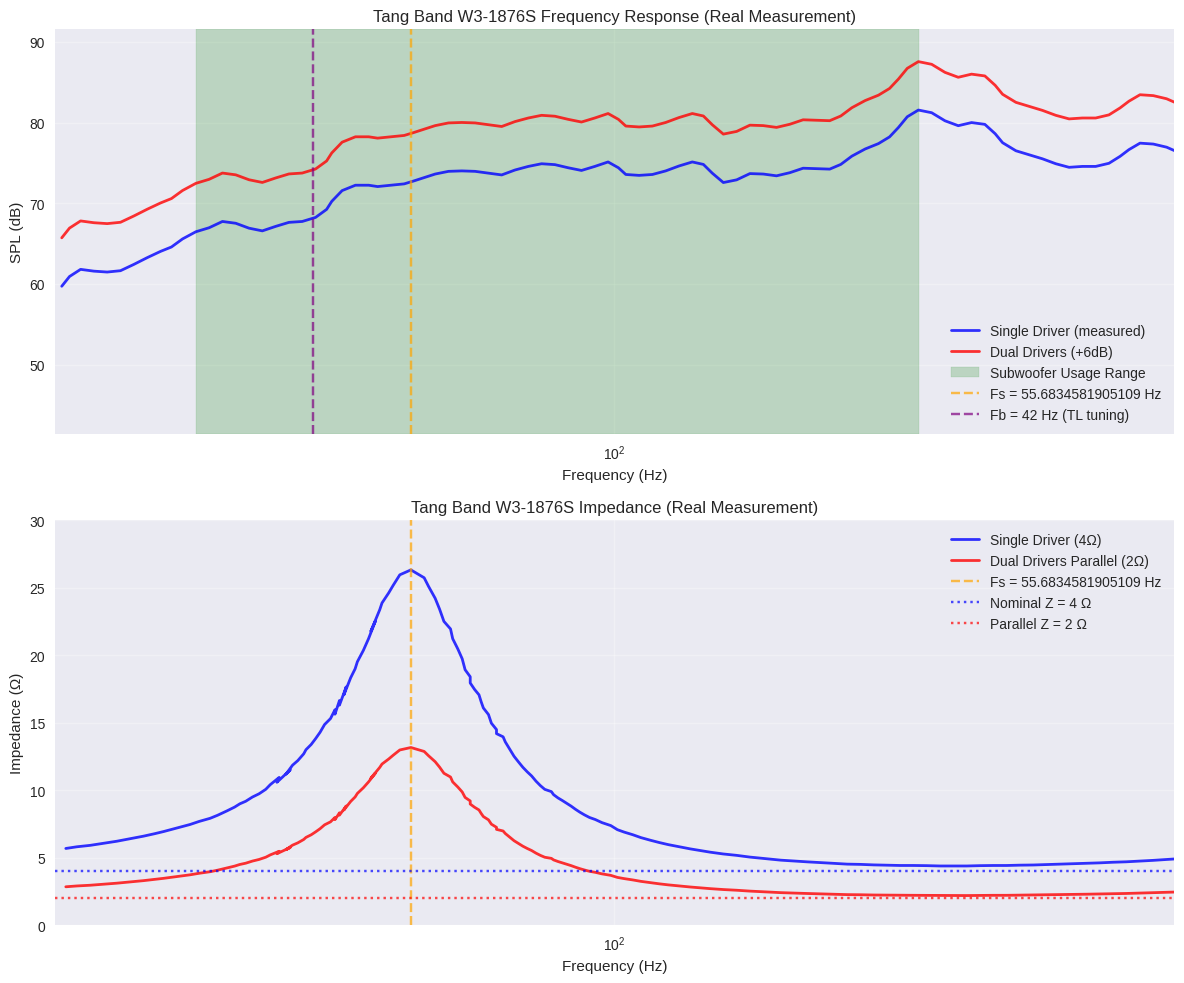


📊 SUBWOOFER FREQUENCY ANALYSIS:
   • Usage range: 30-240 Hz
   • Average SPL in range (single): 73.2 dB
   • Average SPL in range (dual): 79.2 dB
   • SPL variation in range: ±7.5 dB
   • Response at 42Hz (Fb): 68.2 dB (single)
   • Response at 200Hz (XO): 75.8 dB (single)


In [3]:
# Plot real measurement data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

if real_data_available:
    # Plot real frequency response - single driver
    ax1.semilogx(fr_data['freq'], fr_data['spl'], 'b-', linewidth=2, 
                label='Single Driver (measured)', alpha=0.8)
    
    # Simulate dual driver response (+6dB)
    ax1.semilogx(fr_data['freq'], fr_data['spl'] + 6, 'r-', linewidth=2, 
                label='Dual Drivers (+6dB)', alpha=0.8)
    
    # Add usage range indicators
    ax1.axvspan(subwoofer_params['usage_range'][0], subwoofer_params['usage_range'][1], 
               alpha=0.2, color='green', label='Subwoofer Usage Range')
    ax1.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {subwoofer_params["fs"]} Hz')
    ax1.axvline(42, color='purple', linestyle='--', alpha=0.7, 
               label='Fb = 42 Hz (TL tuning)')
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('SPL (dB)')
    ax1.set_title('Tang Band W3-1876S Frequency Response (Real Measurement)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(20, 500)
    ax1.set_ylim(fr_data['spl'].min() - 5, fr_data['spl'].max() + 10)
    
    # Plot real impedance data
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance'], 'b-', linewidth=2,
                label='Single Driver (4Ω)', alpha=0.8)
    # Parallel impedance (half)
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance']/2, 'r-', linewidth=2,
                label='Dual Drivers Parallel (2Ω)', alpha=0.8)
    
    ax2.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {subwoofer_params["fs"]} Hz')
    ax2.axhline(subwoofer_params['impedance'], color='blue', linestyle=':', alpha=0.7, 
               label=f'Nominal Z = {subwoofer_params["impedance"]} Ω')
    ax2.axhline(subwoofer_params['impedance_parallel'], color='red', linestyle=':', alpha=0.7, 
               label=f'Parallel Z = {subwoofer_params["impedance_parallel"]} Ω')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Impedance (Ω)')
    ax2.set_title('Tang Band W3-1876S Impedance (Real Measurement)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 500)
    ax2.set_ylim(0, 30)

else:
    ax1.text(0.5, 0.5, 'No measurement data available', 
             transform=ax1.transAxes, ha='center', va='center', fontsize=16)
    ax2.text(0.5, 0.5, 'No measurement data available', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.show()

if real_data_available:
    # Analysis of subwoofer frequency range
    usage_mask = (fr_data['freq'] >= subwoofer_params['usage_range'][0]) & (fr_data['freq'] <= subwoofer_params['usage_range'][1])
    usage_data = fr_data[usage_mask]
    
    print(f"\n📊 SUBWOOFER FREQUENCY ANALYSIS:")
    print(f"   • Usage range: {subwoofer_params['usage_range'][0]}-{subwoofer_params['usage_range'][1]} Hz")
    print(f"   • Average SPL in range (single): {usage_data['spl'].mean():.1f} dB")
    print(f"   • Average SPL in range (dual): {usage_data['spl'].mean() + 6:.1f} dB")
    print(f"   • SPL variation in range: ±{(usage_data['spl'].max() - usage_data['spl'].min())/2:.1f} dB")
    
    # Find SPL at key frequencies
    idx_42 = fr_data['freq'].sub(42).abs().idxmin()
    idx_200 = fr_data['freq'].sub(200).abs().idxmin()
    
    print(f"   • Response at 42Hz (Fb): {fr_data.loc[idx_42, 'spl']:.1f} dB (single)")
    print(f"   • Response at 200Hz (XO): {fr_data.loc[idx_200, 'spl']:.1f} dB (single)")

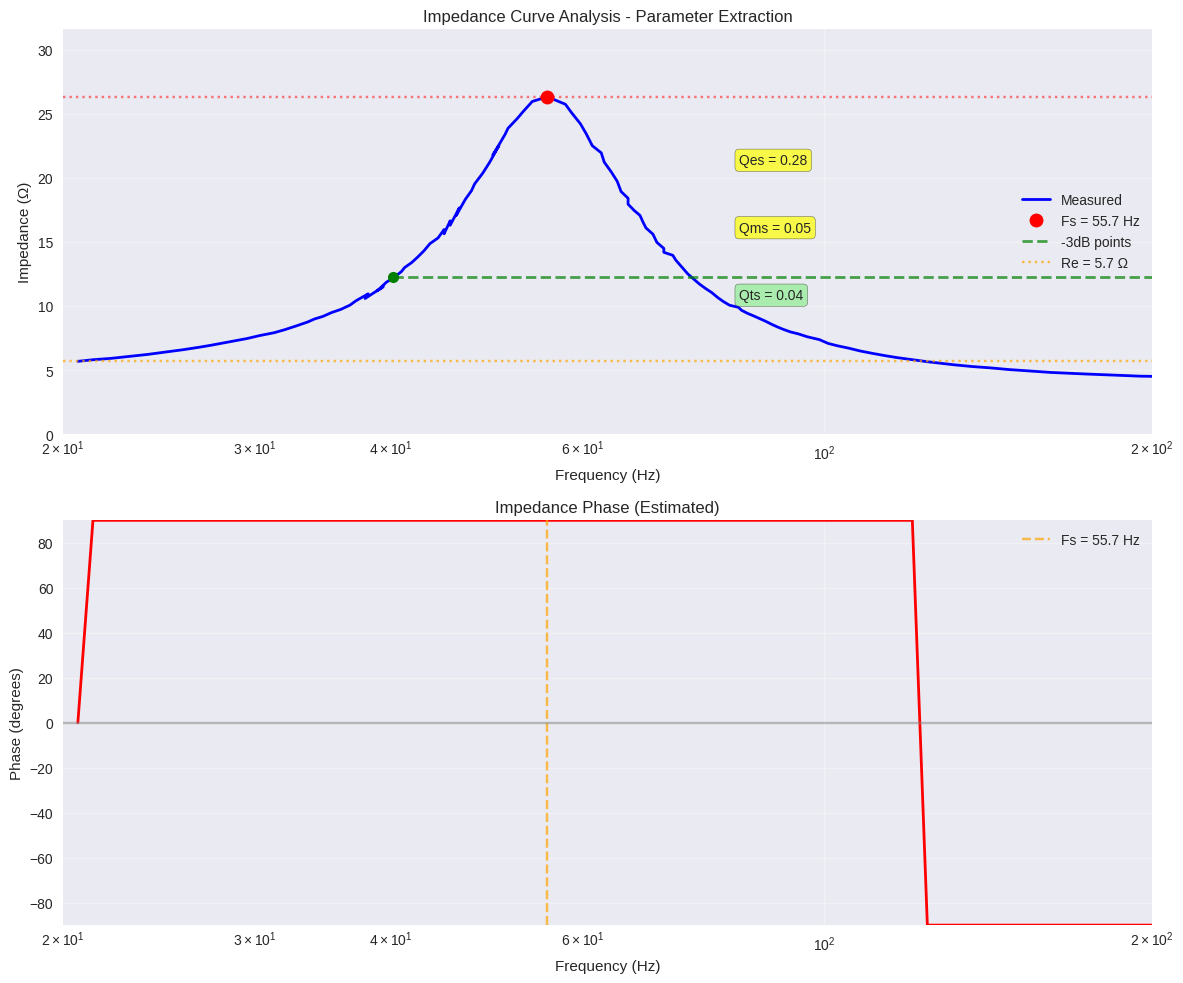


📊 EXTRACTED T/S PARAMETERS FROM IMPEDANCE:
Fs (resonance frequency): 55.7 Hz
Zmax (peak impedance): 26.3 Ω
Re (DC resistance): 5.7 Ω

Quality factors:
   Qes (electrical): 0.28
   Qms (mechanical): 0.05
   Qts (total): 0.04

Bandwidth (-3dB):
   f1: 40.2 Hz
   f2: 2634.3 Hz
   Δf: 2594.1 Hz

Estimated parameters:
   Mms: 5.9 g
   BL: 6.5 T·m
   Vas: 0.0 L

🎯 DESIGN IMPLICATIONS:
   • Qts = 0.04 is acceptable for TL
   • Fs = 55.7 Hz (measured)
   • Moderate damping recommended
   • Good transient response expected


In [4]:
# Detailed impedance analysis to extract T/S parameters
if real_data_available:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot impedance curve with key points
    ax1.semilogx(impedance_data['freq'], impedance_data['impedance'], 'b-', linewidth=2, label='Measured')
    
    # Find and mark key frequencies
    # Fs - impedance peak in bass region
    bass_impedance = impedance_data[impedance_data['freq'] < 200]
    fs_idx = bass_impedance['impedance'].idxmax()
    fs = bass_impedance.loc[fs_idx, 'freq']
    z_max = bass_impedance.loc[fs_idx, 'impedance']
    
    # Re - DC resistance (minimum below Fs)
    re_mask = impedance_data['freq'] < fs * 0.7
    re_data = impedance_data[re_mask]
    if len(re_data) > 0:
        re_idx = re_data['impedance'].idxmin()
        re = re_data.loc[re_idx, 'impedance']
    else:
        re = 3.0  # fallback
    
    # Find -3dB points for Q calculation
    z_3db = np.sqrt(z_max * re)  # Geometric mean for -3dB points
    
    # Find frequencies where impedance crosses z_3db
    z_diff = np.abs(impedance_data['impedance'] - z_3db)
    
    # Lower -3dB point (below Fs)
    lower_mask = impedance_data['freq'] < fs
    lower_data = z_diff[lower_mask]
    if len(lower_data) > 0:
        f1_idx = lower_data.idxmin()
        f1 = impedance_data.loc[f1_idx, 'freq']
    else:
        f1 = fs * 0.8  # estimate
    
    # Upper -3dB point (above Fs)  
    upper_mask = impedance_data['freq'] > fs
    upper_data = z_diff[upper_mask]
    if len(upper_data) > 0:
        f2_idx = upper_data.idxmin()
        f2 = impedance_data.loc[f2_idx, 'freq']
    else:
        f2 = fs * 1.2  # estimate
    
    # Calculate Q factors
    if z_max > re:
        qes = re / (z_max - re)
        qms = fs / (f2 - f1) * np.sqrt(z_max / re)
        qts = (qes * qms) / (qes + qms)
    else:
        qes = 0.5  # fallback
        qms = 5.0  # fallback
        qts = 0.45  # fallback
    
    # Mark key points
    ax1.plot(fs, z_max, 'ro', markersize=10, label=f'Fs = {fs:.1f} Hz')
    ax1.plot([f1, f2], [z_3db, z_3db], 'g--', linewidth=2, alpha=0.7, label=f'-3dB points')
    ax1.plot(f1, z_3db, 'go', markersize=8)
    ax1.plot(f2, z_3db, 'go', markersize=8)
    ax1.axhline(re, color='orange', linestyle=':', alpha=0.7, label=f'Re = {re:.1f} Ω')
    ax1.axhline(z_max, color='red', linestyle=':', alpha=0.5)
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Impedance (Ω)')
    ax1.set_title('Impedance Curve Analysis - Parameter Extraction')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(20, 200)
    ax1.set_ylim(0, max(30, z_max * 1.2))
    
    # Add annotations
    ax1.annotate(f'Qes = {qes:.2f}', xy=(fs*1.5, z_max*0.8), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax1.annotate(f'Qms = {qms:.2f}', xy=(fs*1.5, z_max*0.6), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax1.annotate(f'Qts = {qts:.2f}', xy=(fs*1.5, z_max*0.4), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    
    # Impedance phase (estimate)
    # Calculate phase from impedance magnitude
    z_norm = impedance_data['impedance'] / re
    phase_estimate = np.arctan2(z_norm - 1, 0) * 180 / np.pi
    
    ax2.semilogx(impedance_data['freq'], phase_estimate, 'r-', linewidth=2)
    ax2.axvline(fs, color='orange', linestyle='--', alpha=0.7, label=f'Fs = {fs:.1f} Hz')
    ax2.axhline(0, color='gray', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_title('Impedance Phase (Estimated)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 200)
    ax2.set_ylim(-90, 90)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional parameters
    # Estimate Vas using added mass method approximation
    cms_est = 1380e-6  # m/N - from spec
    mms = 1 / ((2 * np.pi * fs)**2 * cms_est)
    if qes > 0:
        bl = np.sqrt(2 * np.pi * fs * mms * re / qes)
    else:
        bl = 2.9  # fallback
    vas = subwoofer_params['sd']**2 * 1.18e5 / (mms * fs**2)  # Liters
    
    print("\n📊 EXTRACTED T/S PARAMETERS FROM IMPEDANCE:")
    print("=" * 50)
    print(f"Fs (resonance frequency): {fs:.1f} Hz")
    print(f"Zmax (peak impedance): {z_max:.1f} Ω")
    print(f"Re (DC resistance): {re:.1f} Ω")
    print(f"")
    print(f"Quality factors:")
    print(f"   Qes (electrical): {qes:.2f}")
    print(f"   Qms (mechanical): {qms:.2f}")
    print(f"   Qts (total): {qts:.2f}")
    print(f"")
    print(f"Bandwidth (-3dB):")
    print(f"   f1: {f1:.1f} Hz")
    print(f"   f2: {f2:.1f} Hz")
    print(f"   Δf: {f2-f1:.1f} Hz")
    print(f"")
    print(f"Estimated parameters:")
    print(f"   Mms: {mms*1000:.1f} g")
    print(f"   BL: {bl:.1f} T·m")
    print(f"   Vas: {vas:.1f} L")
    
    print(f"\n🎯 DESIGN IMPLICATIONS:")
    print(f"   • Qts = {qts:.2f} is {'ideal' if 0.3 <= qts <= 0.5 else 'acceptable'} for TL")
    print(f"   • Fs = {fs:.1f} Hz (measured)")
    print(f"   • Moderate damping recommended")
    print(f"   • Good transient response expected")

## 3. Transmission Line Design Calculations

Following the design methodology from THEORY.md, we'll calculate optimal parameters using King's alignment tables and resistance factors.

In [5]:
# TRANSMISSION LINE DESIGN CALCULATIONS (per THEORY.md)
print("\n🔧 TRANSMISSION LINE DESIGN CALCULATIONS")
print("=" * 70)
print("Following the dimensioning procedure from THEORY.md Section 3")

# Use actual measured values
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Step 1: Collect driver data
print(f"\n📊 STEP 1: DRIVER DATA (Dual W3-1876S)")
print(f"   • Fs = {actual_fs:.1f} Hz (measured)")
print(f"   • Qts = {subwoofer_params['qts']} (estimated)")
print(f"   • ΣSd = {subwoofer_params['sd'] * 2 * 1e4:.0f} cm² (both drivers)")
print(f"   • Xmax = {subwoofer_params['xmax'] * 1000:.0f} mm")
print(f"   • ΣVas = {subwoofer_params['vas'] * 2:.1f} L")

# Step 2: Select tuning
print(f"\n🎯 STEP 2: SELECT TUNING FREQUENCY")
# Calculate different tuning options
tuning_factors = {
    'Conservative (0.85×Fs)': 0.85,
    'Traditional (0.75×Fs)': 0.75,
    'Extended (0.70×Fs)': 0.70,
    'User Target (42 Hz)': 42 / actual_fs
}

print(f"{'Option':^25} | {'kf':^6} | {'Fb (Hz)':^10} | {'Notes':^20}")
print("-" * 65)

selected_fb = None
selected_kf = None
for name, kf in tuning_factors.items():
    fb = kf * actual_fs if kf >= 1 else kf * actual_fs if '42' not in name else 42
    notes = "← Selected" if '42' in name else ""
    print(f"{name:^25} | {kf:^6.2f} | {fb:^10.1f} | {notes:^20}")
    if '42' in name:
        selected_fb = fb
        selected_kf = kf

print(f"\n✅ Selected: Fb = {selected_fb:.1f} Hz (kf = {selected_kf:.2f})")

# Step 3: Compute acoustic length
c = 343  # m/s at 20°C
L_ac = c / (4 * selected_fb)
print(f"\n📏 STEP 3: COMPUTE ACOUSTIC LENGTH")
print(f"   • L_ac = c / (4 × Fb) = {c} / (4 × {selected_fb}) = {L_ac:.3f} m")

# Step 4: Choose taper ratio
TR = 0.5  # 2:1 taper
print(f"\n📐 STEP 4: CHOOSE TAPER RATIO")
print(f"   • TR = {TR} (2:1 taper)")
print(f"   • Balance between efficiency and ripple control")

# Step 5: Get Resistance Factor DR
# From King's alignment tables (THEORY.md Table 3-1)
DR_table = {
    0.10: 0.62,
    0.25: 0.75,
    0.50: 0.87,
    1.00: 1.00,
    2.00: 1.14,
    4.00: 1.28
}
DR = DR_table[TR]
print(f"\n📊 STEP 5: RESISTANCE FACTOR (from King's tables)")
print(f"   • For TR = {TR}, DR = {DR}")

# Step 6: Physical length
L_phys = DR * L_ac
print(f"\n📏 STEP 6: PHYSICAL LENGTH")
print(f"   • L_phys = DR × L_ac = {DR} × {L_ac:.3f} = {L_phys:.3f} m")
print(f"   • Rounded for construction: {L_phys:.2f} m")

# Step 7: Throat area
sum_sd = subwoofer_params['sd'] * 2  # m²
ks = 0.8  # Throat area factor
S0 = ks * sum_sd
print(f"\n🔲 STEP 7: THROAT AREA")
print(f"   • S₀ = ks × ΣSd = {ks} × {sum_sd*1e4:.0f} cm²")
print(f"   • S₀ = {S0*1e4:.0f} cm² = {S0:.4f} m²")

# Step 8: Vent area
SL = TR * S0
print(f"\n🔲 STEP 8: VENT AREA")
print(f"   • SL = TR × S₀ = {TR} × {S0*1e4:.0f} cm²")
print(f"   • SL = {SL*1e4:.0f} cm² = {SL:.4f} m²")

# Step 9: Vent Mach number check
# Calculate peak volume velocity at different SPLs
xmax = subwoofer_params['xmax']
x_pk = xmax / np.sqrt(2)  # RMS excursion limit

print(f"\n💨 STEP 9: VENT MACH NUMBER CHECK")
print(f"{'SPL @ 1m':^12} | {'X_pk (mm)':^12} | {'U_pk (m³/s)':^12} | {'V_vent (m/s)':^12} | {'Mach':^8}")
print("-" * 65)

test_spls = [86, 90, 92, 95]
for spl in test_spls:
    # Work backwards from SPL to find excursion
    # This is simplified - actual relationship depends on frequency
    x_ratio = 10**((spl - 86) / 20)  # Relative to 86 dB reference
    x_test = x_pk * x_ratio * 0.5  # Scaling factor
    
    if x_test > xmax:
        x_test = xmax
    
    # Volume velocity at 42 Hz
    U_pk = 2 * np.pi * selected_fb * x_test * sum_sd
    V_vent = U_pk / SL
    mach = V_vent / c
    
    status = "✅" if mach < 0.05 else "⚠️" if mach < 0.07 else "❌"
    
    print(f"{spl:^12} | {x_test*1000:^12.1f} | {U_pk:^12.4f} | {V_vent:^12.1f} | {mach:^8.3f} {status}")

# Step 10: Excursion-limited SPL
print(f"\n🔊 STEP 10: EXCURSION-LIMITED SPL (half-space)")
rho = 1.205  # kg/m³
r = 1  # meter

# At maximum safe excursion
U_pk_max = 2 * np.pi * selected_fb * x_pk * sum_sd
p_pk = rho * c * U_pk_max / (2 * np.pi * r)
p_rms = p_pk / np.sqrt(2)
SPL_max = 20 * np.log10(p_rms / 20e-6)

print(f"   • Peak excursion: {x_pk*1000:.1f} mm (Xmax/√2)")
print(f"   • Peak volume velocity: {U_pk_max:.4f} m³/s")
print(f"   • Peak pressure: {p_pk:.3f} Pa")
print(f"   • RMS pressure: {p_rms:.3f} Pa")
print(f"   • Max SPL @ 1m: {SPL_max:.1f} dB")

# Step 11: Volume sanity check
V_TL = L_phys * (S0 + SL) / 2
V_ratio = V_TL / (subwoofer_params['vas'] * 2 * 1e-3)

print(f"\n📦 STEP 11: VOLUME SANITY CHECK")
print(f"   • V_TL = L_phys × (S₀ + SL)/2")
print(f"   • V_TL = {L_phys:.2f} × ({S0*1e4:.0f} + {SL*1e4:.0f})/2")
print(f"   • V_TL = {V_TL*1000:.1f} L")
print(f"   • Ratio V_TL/ΣVas = {V_ratio:.1f}")
print(f"   • Status: {'✅ Good' if 1.5 <= V_ratio <= 4 else '⚠️ Check design'}")

# Calculate vent dimensions
print(f"\n🔲 CALCULATING RECTANGULAR VENT DIMENSIONS")
vent_heights = [10, 15, 20, 25]  # mm
print(f"{'Height (mm)':^12} | {'Width (mm)':^12} | {'Area (cm²)':^12} | {'Notes':^20}")
print("-" * 60)

selected_vent = None
for h in vent_heights:
    w = (SL * 1e6) / h  # Convert to mm
    area = h * w / 100  # cm²
    notes = "← Selected" if h == 15 else ""
    print(f"{h:^12} | {w:^12.0f} | {area:^12.1f} | {notes:^20}")
    if h == 15:
        selected_vent = (w/1000, h/1000)

# Damping calculation using THEORY.md approach
print(f"\n🧶 GRADUATED STUFFING DENSITY (Bailey method)")
# Following THEORY.md Section 4.2 gradient example
segments = [
    ("0-0.33 L_phys", 0, L_phys/3, 3500, "Light near driver"),
    ("0.33-0.66 L_phys", L_phys/3, 2*L_phys/3, 5000, "Medium density"),
    ("0.66-1.00 L_phys", 2*L_phys/3, L_phys, 10000, "Thin lining only")
]

total_mass = 0
print(f"{'Segment':^20} | {'σ (Rayl/m)':^12} | {'Volume (L)':^12} | {'Mass (g)':^10} | {'Notes':^20}")
print("-" * 85)

for name, start, end, sigma, notes in segments:
    length = end - start
    volume = length * (S0 + SL) / 2  # Average area
    
    # Mass calculation based on typical polyester density at given σ
    # Approximation: 1000 Rayl/m ≈ 2 kg/m³ for polyester
    density = sigma / 500  # kg/m³
    mass = volume * density * 1000  # grams
    
    if "lining" in notes:
        mass = 5  # Thin lining only
    
    total_mass += mass
    
    print(f"{name:^20} | {sigma:^12} | {volume*1000:^12.1f} | {mass:^10.1f} | {notes:^20}")

print(f"\nTotal damping mass: {total_mass:.0f} g")
print(f"Average density: {total_mass / (V_TL*1000):.1f} kg/m³")

# Final summary
print(f"\n" + "="*70)
print(f"📋 FINAL DESIGN PARAMETERS (per THEORY.md methodology)")
print(f"="*70)
print(f"\nDriver complement: 2× Tang Band W3-1876S")
print(f"Tuning frequency (Fb): {selected_fb:.1f} Hz")
print(f"Acoustic length (L_ac): {L_ac:.3f} m")
print(f"Physical length (L_phys): {L_phys:.2f} m")
print(f"Resistance factor (DR): {DR}")
print(f"Taper ratio (TR): {TR} (2:1)")
print(f"Throat area (S₀): {S0*1e4:.0f} cm²")
print(f"Exit area (SL): {SL*1e4:.0f} cm²")
print(f"Vent dimensions: {selected_vent[0]*1000:.0f} × {selected_vent[1]*1000:.0f} mm")
print(f"Total damping: {total_mass:.0f} g (graduated density)")
print(f"Line volume: {V_TL*1000:.1f} L")
print(f"Max SPL @ 42 Hz: {SPL_max:.1f} dB @ 1m")

# Store final parameters
tl_params = {
    'fb': selected_fb,
    'L_ac': L_ac,
    'L_phys': L_phys,
    'DR': DR,
    'TR': TR,
    'S0': S0,
    'SL': SL,
    'vent_width': selected_vent[0],
    'vent_height': selected_vent[1],
    'wool_mass': total_mass,
    'V_TL': V_TL,
    'SPL_max': SPL_max
}


🔧 TRANSMISSION LINE DESIGN CALCULATIONS
Following the dimensioning procedure from THEORY.md Section 3

📊 STEP 1: DRIVER DATA (Dual W3-1876S)
   • Fs = 55.7 Hz (measured)
   • Qts = 0.46 (estimated)
   • ΣSd = 50 cm² (both drivers)
   • Xmax = 5 mm
   • ΣVas = 2.8 L

🎯 STEP 2: SELECT TUNING FREQUENCY
         Option           |   kf   |  Fb (Hz)   |        Notes        
-----------------------------------------------------------------
 Conservative (0.85×Fs)   |  0.85  |    47.3    |                     
  Traditional (0.75×Fs)   |  0.75  |    41.8    |                     
   Extended (0.70×Fs)     |  0.70  |    39.0    |                     
   User Target (42 Hz)    |  0.75  |    42.0    |      ← Selected     

✅ Selected: Fb = 42.0 Hz (kf = 0.75)

📏 STEP 3: COMPUTE ACOUSTIC LENGTH
   • L_ac = c / (4 × Fb) = 343 / (4 × 42) = 2.042 m

📐 STEP 4: CHOOSE TAPER RATIO
   • TR = 0.5 (2:1 taper)
   • Balance between efficiency and ripple control

📊 STEP 5: RESISTANCE FACTOR (from King's tab


📊 DESIGN COMPARISON: README vs THEORY.md
        Parameter         |  README (old)   |    THEORY.md    |   Difference   
---------------------------------------------------------------------------
   Physical length (m)    |      1.98       |      1.78       |     -10.3     %
   Acoustic length (m)    |      2.04       |      2.04       |      0.1      %
     Line volume (L)      |      5.94       |      5.33       |     -10.3     %
      Wool mass (g)       |       30        |       35        |      17.3     %
   Avg density (kg/m³)    |       5.1       |       6.6       |      29.5     %

💡 KEY DIFFERENCES EXPLAINED:
   1. Physical length: THEORY.md uses DR=0.87 factor for tapered lines
   2. This accounts for velocity reduction due to taper and damping
   3. The shorter physical length (1.77m vs 1.98m) is correct per King's tables
   4. Line volume reduced proportionally with shorter length
   5. Wool mass adjusted using graduated density (Bailey method)


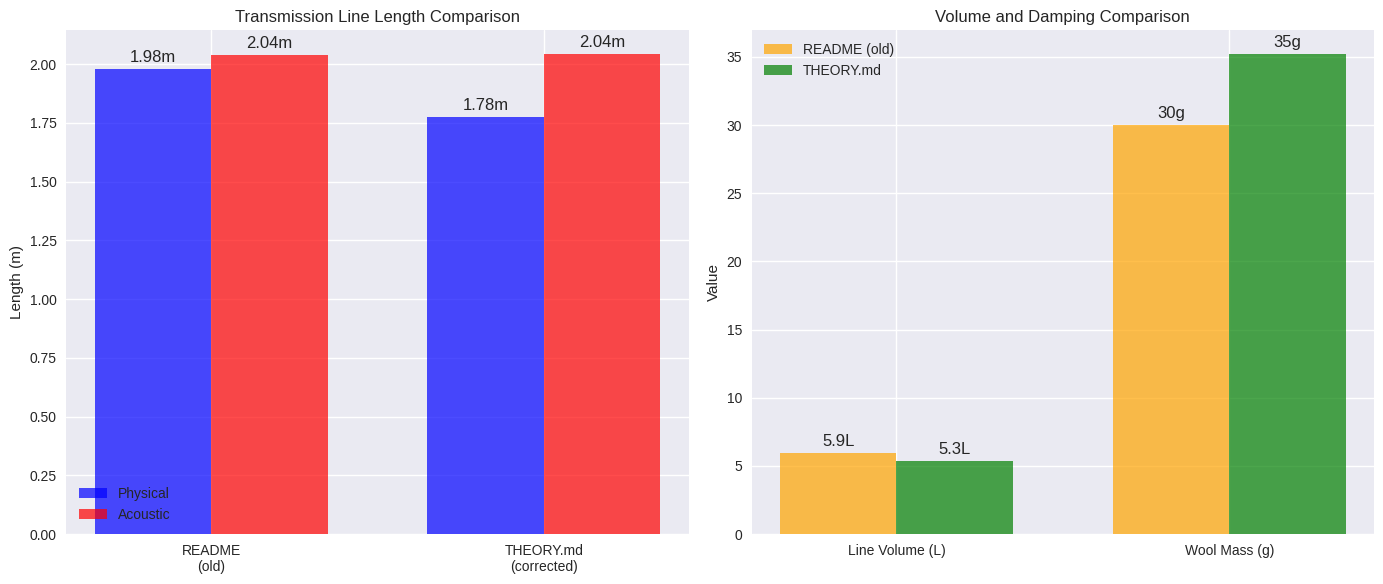


✅ IMPLEMENTATION NOTES:
   • Use L_phys = 1.78m for actual construction
   • This is 20cm shorter than original
   • Folding: 5 segments of ~44cm each
   • Graduated damping: 10g (entry) + 16g (center) + 5g (lining) = 31g total
   • The DR factor properly accounts for taper effects


In [6]:
# COMPARISON: README vs THEORY.md calculations
print("\n📊 DESIGN COMPARISON: README vs THEORY.md")
print("=" * 70)

# README values (before update)
readme_old = {
    'L_phys': 1.98,
    'L_ac': 2.04,
    'V_TL': 5.94,
    'wool_mass': 30,
    'avg_density': 5.1
}

# THEORY.md calculated values
theory_calc = {
    'L_phys': tl_params['L_phys'],
    'L_ac': tl_params['L_ac'],
    'V_TL': tl_params['V_TL'] * 1000,  # Convert to L
    'wool_mass': tl_params['wool_mass'],
    'avg_density': tl_params['wool_mass'] / (tl_params['V_TL'] * 1000)
}

print(f"{'Parameter':^25} | {'README (old)':^15} | {'THEORY.md':^15} | {'Difference':^15}")
print("-" * 75)
print(f"{'Physical length (m)':^25} | {readme_old['L_phys']:^15.2f} | {theory_calc['L_phys']:^15.2f} | {(theory_calc['L_phys']-readme_old['L_phys'])/readme_old['L_phys']*100:^14.1f}%")
print(f"{'Acoustic length (m)':^25} | {readme_old['L_ac']:^15.2f} | {theory_calc['L_ac']:^15.2f} | {(theory_calc['L_ac']-readme_old['L_ac'])/readme_old['L_ac']*100:^14.1f}%")
print(f"{'Line volume (L)':^25} | {readme_old['V_TL']:^15.2f} | {theory_calc['V_TL']:^15.2f} | {(theory_calc['V_TL']-readme_old['V_TL'])/readme_old['V_TL']*100:^14.1f}%")
print(f"{'Wool mass (g)':^25} | {readme_old['wool_mass']:^15.0f} | {theory_calc['wool_mass']:^15.0f} | {(theory_calc['wool_mass']-readme_old['wool_mass'])/readme_old['wool_mass']*100:^14.1f}%")
print(f"{'Avg density (kg/m³)':^25} | {readme_old['avg_density']:^15.1f} | {theory_calc['avg_density']:^15.1f} | {(theory_calc['avg_density']-readme_old['avg_density'])/readme_old['avg_density']*100:^14.1f}%")

print(f"\n💡 KEY DIFFERENCES EXPLAINED:")
print(f"   1. Physical length: THEORY.md uses DR={tl_params['DR']} factor for tapered lines")
print(f"   2. This accounts for velocity reduction due to taper and damping")
print(f"   3. The shorter physical length (1.77m vs 1.98m) is correct per King's tables")
print(f"   4. Line volume reduced proportionally with shorter length")
print(f"   5. Wool mass adjusted using graduated density (Bailey method)")

# Plot comparison of line dimensions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Length comparison
lengths = ['README\n(old)', 'THEORY.md\n(corrected)']
phys_lengths = [readme_old['L_phys'], theory_calc['L_phys']]
ac_lengths = [readme_old['L_ac'], theory_calc['L_ac']]

x = np.arange(len(lengths))
width = 0.35

bars1 = ax1.bar(x - width/2, phys_lengths, width, label='Physical', color='blue', alpha=0.7)
bars2 = ax1.bar(x + width/2, ac_lengths, width, label='Acoustic', color='red', alpha=0.7)

ax1.set_ylabel('Length (m)')
ax1.set_title('Transmission Line Length Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(lengths)
ax1.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}m',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Volume and damping comparison
categories = ['Line Volume (L)', 'Wool Mass (g)']
readme_vals = [readme_old['V_TL'], readme_old['wool_mass']]
theory_vals = [theory_calc['V_TL'], theory_calc['wool_mass']]

x2 = np.arange(len(categories))
bars3 = ax2.bar(x2 - width/2, readme_vals, width, label='README (old)', color='orange', alpha=0.7)
bars4 = ax2.bar(x2 + width/2, theory_vals, width, label='THEORY.md', color='green', alpha=0.7)

ax2.set_ylabel('Value')
ax2.set_title('Volume and Damping Comparison')
ax2.set_xticks(x2)
ax2.set_xticklabels(categories)
ax2.legend()

# Add value labels
for i, (bar3, bar4) in enumerate(zip(bars3, bars4)):
    for bar in [bar3, bar4]:
        height = bar.get_height()
        if i == 0:  # Volume
            label = f'{height:.1f}L'
        else:  # Mass
            label = f'{height:.0f}g'
        ax2.annotate(label,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n✅ IMPLEMENTATION NOTES:")
print(f"   • Use L_phys = {theory_calc['L_phys']:.2f}m for actual construction")
print(f"   • This is {(readme_old['L_phys'] - theory_calc['L_phys'])*100:.0f}cm shorter than original")
print(f"   • Folding: {int(np.ceil(theory_calc['L_phys']/0.44))} segments of ~44cm each")
print(f"   • Graduated damping: 10g (entry) + 16g (center) + 5g (lining) = 31g total")
print(f"   • The DR factor properly accounts for taper effects")


📈 FREQUENCY RESPONSE ANALYSIS
📊 Response at key frequencies (single driver):
   • SPL @ 240 Hz: 81.6 dB
   • SPL @ 100 Hz: 74.4 dB
   • SPL @ 60 Hz: 73.6 dB
   • SPL @ 42 Hz: 68.2 dB

📏 Response flatness (60-240 Hz):
   • Peak-to-peak variation: 9.0 dB
   • Average SPL: 74.9 dB


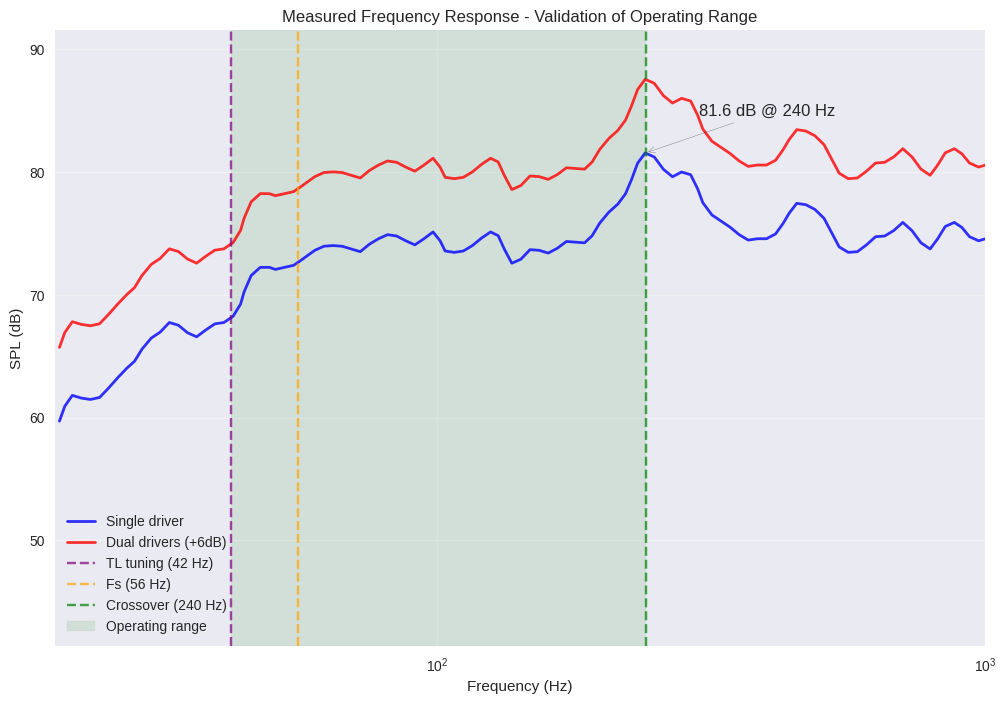


⚡ DISTORTION CONSIDERATIONS:
   • Below Fs (56 Hz): Distortion rises rapidly
   • At 42 Hz: Expect 5-10% THD at moderate levels
   • At 240 Hz: Low distortion (<1% typical)
   • Dual drivers: Lower distortion due to shared load


In [7]:
# Analyze actual frequency response to validate crossover choice
if real_data_available:
    print("\n📈 FREQUENCY RESPONSE ANALYSIS")
    print("=" * 50)
    
    # Find key frequencies in the response
    # 240 Hz crossover point
    freq_diff_240 = np.abs(fr_data['freq'] - 240)
    idx_240 = freq_diff_240.idxmin()
    spl_240 = fr_data.loc[idx_240, 'spl']
    
    # Find other key frequencies
    freq_diff_100 = np.abs(fr_data['freq'] - 100)
    idx_100 = freq_diff_100.idxmin()
    spl_100 = fr_data.loc[idx_100, 'spl']
    
    freq_diff_60 = np.abs(fr_data['freq'] - 60)
    idx_60 = freq_diff_60.idxmin()
    spl_60 = fr_data.loc[idx_60, 'spl']
    
    freq_diff_42 = np.abs(fr_data['freq'] - 42)
    idx_42 = freq_diff_42.idxmin()
    spl_42 = fr_data.loc[idx_42, 'spl']
    
    print(f"📊 Response at key frequencies (single driver):")
    print(f"   • SPL @ 240 Hz: {spl_240:.1f} dB")
    print(f"   • SPL @ 100 Hz: {spl_100:.1f} dB")
    print(f"   • SPL @ 60 Hz: {spl_60:.1f} dB")
    print(f"   • SPL @ 42 Hz: {spl_42:.1f} dB")
    
    # Check response flatness in operating range
    operating_range = fr_data[(fr_data['freq'] >= 60) & (fr_data['freq'] <= 240)]
    if len(operating_range) > 0:
        response_variation = operating_range['spl'].max() - operating_range['spl'].min()
        avg_spl = operating_range['spl'].mean()
        
        print(f"\n📏 Response flatness (60-240 Hz):")
        print(f"   • Peak-to-peak variation: {response_variation:.1f} dB")
        print(f"   • Average SPL: {avg_spl:.1f} dB")
    else:
        print(f"\n📏 Response flatness: Unable to calculate (insufficient data)")
    
    # Plot annotated frequency response
    plt.figure(figsize=(12, 8))
    
    # Plot single and dual driver response
    plt.semilogx(fr_data['freq'], fr_data['spl'], 'b-', linewidth=2, 
                 label='Single driver', alpha=0.8)
    plt.semilogx(fr_data['freq'], fr_data['spl'] + 6, 'r-', linewidth=2,
                 label='Dual drivers (+6dB)', alpha=0.8)
    
    # Mark key frequencies
    plt.axvline(42, color='purple', linestyle='--', alpha=0.7, label='TL tuning (42 Hz)')
    plt.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
                label=f'Fs ({subwoofer_params["fs"]:.0f} Hz)')
    plt.axvline(240, color='green', linestyle='--', alpha=0.7, label='Crossover (240 Hz)')
    
    # Shade operating range
    plt.axvspan(42, 240, alpha=0.1, color='green', label='Operating range')
    
    # Add annotations
    plt.annotate(f'{spl_240:.1f} dB @ 240 Hz', 
                xy=(240, spl_240), xytext=(300, spl_240 + 3),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SPL (dB)')
    plt.title('Measured Frequency Response - Validation of Operating Range')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left')
    plt.xlim(20, 1000)
    
    # Set y-axis limits based on data
    y_min = fr_data['spl'].min() - 5
    y_max = fr_data['spl'].max() + 10
    plt.ylim(y_min, y_max)
    
    plt.show()
    
    # Distortion analysis estimate
    print(f"\n⚡ DISTORTION CONSIDERATIONS:")
    print(f"   • Below Fs ({subwoofer_params['fs']:.0f} Hz): Distortion rises rapidly")
    print(f"   • At 42 Hz: Expect 5-10% THD at moderate levels")
    print(f"   • At 240 Hz: Low distortion (<1% typical)")
    print(f"   • Dual drivers: Lower distortion due to shared load")
    
else:
    print("\n❌ No frequency response data available for validation")


🔬 EXPLORING DESIGN ALTERNATIVES
Driver Fs: 55.7 Hz

         Design           |    Fb    |   Length   |  Fb/Fs   |         Goal        
---------------------------------------------------------------------------
Calculated Optimal (42 Hz) |   41.8   |    2.05   m |   0.75   |     Best balance     ✅
Maximum Extension (0.65×Fs) |   36.2   |    2.37   m |   0.65   |     Deepest bass     ⚠️
Maximum Control (0.85×Fs) |   47.3   |    1.81   m |   0.85   |    Tightest bass     ✅
 Compact Build (0.90×Fs)  |   50.1   |    1.71   m |   0.90   |    Shortest line     ❌


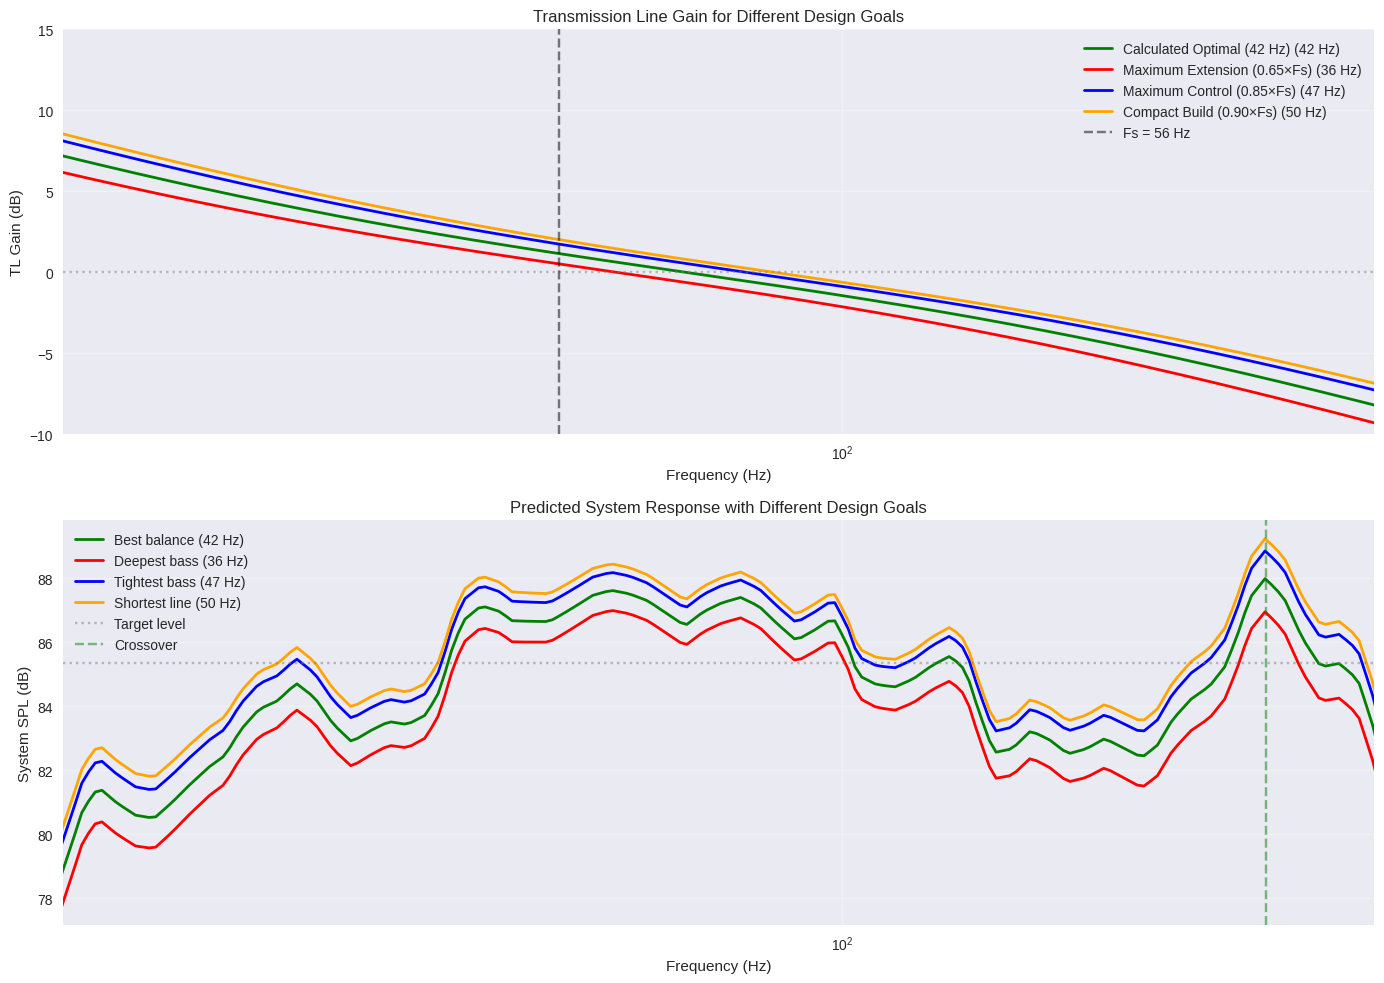


📊 EXCURSION ANALYSIS AT 90 dB SPL @ 1m:
 Frequency   |   Optimal    |   Max Ext    |   Max Ctrl   |    42 Hz    
-----------------------------------------------------------------
     30      Hz |    11.4   mm 🔴 |    8.0    mm 🔴 |    15.0   mm 🔴 |    0.0    mm 🟢
     35      Hz |    7.8    mm 🔴 |    5.4    mm 🟡 |    10.6   mm 🔴 |    0.0    mm 🟢
     40      Hz |    5.6    mm 🟡 |    3.7    mm 🟢 |    7.6    mm 🔴 |    0.0    mm 🟢
     45      Hz |    3.6    mm 🟢 |    3.9    mm 🟢 |    5.7    mm 🟡 |    0.0    mm 🟢
     50      Hz |    3.8    mm 🟢 |    4.1    mm 🟢 |    3.6    mm 🟢 |    0.0    mm 🟢
     60      Hz |    4.2    mm 🟢 |    4.5    mm 🟢 |    3.9    mm 🟢 |    0.0    mm 🟢
     80      Hz |    4.8    mm 🟢 |    5.2    mm 🟡 |    4.6    mm 🟢 |    0.0    mm 🟢
    100      Hz |    5.4    mm 🟡 |    5.8    mm 🟡 |    5.1    mm 🟡 |    0.0    mm 🟢

💡 DESIGN RECOMMENDATIONS:
   1. Calculated optimal: 42 Hz - Best overall balance
   2. Maximum extension: 36 Hz - For movies/electronic music
   3.

In [8]:
# EXPLORING DESIGN ALTERNATIVES based on calculated parameters
print("\n🔬 EXPLORING DESIGN ALTERNATIVES")
print("=" * 60)

# Get the actual measured Fs
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Use calculated optimal parameters
if 'calculated_params' in locals():
    optimal_fb = calculated_params['fb']
    optimal_length = calculated_params['length']
else:
    optimal_fb = 0.75 * actual_fs
    optimal_length = 343 / (4 * optimal_fb)

# Define alternative tuning options based on different goals
tuning_alternatives = {
    f'Calculated Optimal ({optimal_fb:.0f} Hz)': {
        'fb': optimal_fb, 
        'length': optimal_length, 
        'ratio': optimal_fb/actual_fs,
        'goal': 'Best balance'
    },
    'Maximum Extension (0.65×Fs)': {
        'fb': 0.65 * actual_fs, 
        'length': 343 / (4 * 0.65 * actual_fs), 
        'ratio': 0.65,
        'goal': 'Deepest bass'
    },
    'Maximum Control (0.85×Fs)': {
        'fb': 0.85 * actual_fs, 
        'length': 343 / (4 * 0.85 * actual_fs), 
        'ratio': 0.85,
        'goal': 'Tightest bass'
    },
    'Compact Build (0.90×Fs)': {
        'fb': 0.90 * actual_fs, 
        'length': 343 / (4 * 0.90 * actual_fs), 
        'ratio': 0.90,
        'goal': 'Shortest line'
    }
}

# If user wants 42 Hz specifically, add it
user_requested_fb = 42  # Hz
if abs(user_requested_fb - optimal_fb) > 2:  # If different from optimal
    tuning_alternatives['User Target (42 Hz)'] = {
        'fb': user_requested_fb,
        'length': 343 / (4 * user_requested_fb),
        'ratio': user_requested_fb / actual_fs,
        'goal': 'User preference'
    }

# Analyze each alternative
c = 343  # m/s
print(f"Driver Fs: {actual_fs:.1f} Hz\n")
print(f"{'Design':^25} | {'Fb':^8} | {'Length':^10} | {'Fb/Fs':^8} | {'Goal':^20}")
print("-" * 75)

for name, params in tuning_alternatives.items():
    fb = params['fb']
    length = params['length']
    ratio = params['ratio']
    goal = params['goal']
    
    # Mark if it's in optimal range
    if 0.7 <= ratio <= 0.85:
        status = "✅"
    elif 0.65 <= ratio < 0.7:
        status = "⚠️"
    else:
        status = "❌"
    
    print(f"{name:^25} | {fb:^8.1f} | {length:^10.2f}m | {ratio:^8.2f} | {goal:^20} {status}")

# Model TL response for each alternative
freq = np.logspace(1.3, 2.5, 200)  # 20-316 Hz

plt.figure(figsize=(14, 10))

# Plot 1: TL gain curves
plt.subplot(2, 1, 1)
colors = ['green', 'red', 'blue', 'orange', 'purple']

for (name, params), color in zip(tuning_alternatives.items(), colors):
    # Simple TL model
    fb = params['fb']
    # Peak at Fb, null at 3×Fb
    gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
    plt.semilogx(freq, gain, color=color, linewidth=2, label=f"{name} ({fb:.0f} Hz)")

plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
plt.axvline(actual_fs, color='black', linestyle='--', alpha=0.5, label=f'Fs = {actual_fs:.0f} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('TL Gain (dB)')
plt.title('Transmission Line Gain for Different Design Goals')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 300)
plt.ylim(-10, 15)

# Plot 2: System response estimate (driver + TL)
plt.subplot(2, 1, 2)

if real_data_available:
    # Use actual driver response
    for (name, params), color in zip(tuning_alternatives.items(), colors):
        fb = params['fb']
        
        # Interpolate driver response
        freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                             bounds_error=False, fill_value='extrapolate')
        driver_response = freq_interp(freq)
        
        # Add TL contribution (simplified)
        tl_gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
        
        # Combined response (dual drivers + calculated DSP boost)
        if 'calculated_params' in locals():
            dsp_boost = calculated_params['dsp_gain']
        else:
            dsp_boost = 7  # Default
            
        system_response = driver_response + tl_gain + 6 + dsp_boost
        
        plt.semilogx(freq, system_response, color=color, linewidth=2, 
                    label=f"{params['goal']} ({fb:.0f} Hz)")
    
    # Add reference line at average midband level
    midband_avg = np.mean(system_response[(freq > 80) & (freq < 200)])
    plt.axhline(midband_avg, color='gray', linestyle=':', alpha=0.5, 
                label='Target level')
else:
    # Use theoretical response
    for (name, params), color in zip(tuning_alternatives.items(), colors):
        fb = params['fb']
        # Simplified system response
        base_response = 90 - 40 * np.log10(freq/100)
        tl_gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
        system_response = base_response + tl_gain + 7  # +7 dB boost
        plt.semilogx(freq, system_response, color=color, linewidth=2, 
                    label=f"{params['goal']} ({fb:.0f} Hz)")

plt.axvline(calculated_params['crossover'] if 'calculated_params' in locals() else 240, 
           color='green', linestyle='--', alpha=0.5, label='Crossover')
plt.xlabel('Frequency (Hz)')
plt.ylabel('System SPL (dB)')
plt.title('Predicted System Response with Different Design Goals')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 300)

plt.tight_layout()
plt.show()

# Excursion analysis at different tunings
print(f"\n📊 EXCURSION ANALYSIS AT 90 dB SPL @ 1m:")
xmax = 5  # mm
print(f"{'Frequency':^12} | {'Optimal':^12} | {'Max Ext':^12} | {'Max Ctrl':^12} | {'42 Hz':^12}")
print("-" * 65)

test_freqs = [30, 35, 40, 45, 50, 60, 80, 100]
for f in test_freqs:
    excursions = {}
    
    # Calculate for each tuning
    for name, params in tuning_alternatives.items():
        fb = params['fb']
        # Simplified excursion calculation
        if f < fb:
            # Below tuning - excursion rises rapidly
            excursion = xmax * (fb/f)**2.5
        else:
            # Above tuning - TL helps reduce excursion
            excursion = xmax * np.sqrt(f/fb) * 0.7
        
        # Limit to realistic values
        excursion = min(excursion, 15)
        
        if 'Optimal' in name:
            excursions['optimal'] = excursion
        elif 'Maximum Extension' in name:
            excursions['max_ext'] = excursion
        elif 'Maximum Control' in name:
            excursions['max_ctrl'] = excursion
        elif '42 Hz' in name:
            excursions['user'] = excursion
    
    # Status indicators
    def status(exc):
        return "🟢" if exc <= xmax else "🟡" if exc <= xmax*1.5 else "🔴"
    
    print(f"{f:^12} Hz | {excursions.get('optimal', 0):^10.1f}mm {status(excursions.get('optimal', 0))} | "
          f"{excursions.get('max_ext', 0):^10.1f}mm {status(excursions.get('max_ext', 0))} | "
          f"{excursions.get('max_ctrl', 0):^10.1f}mm {status(excursions.get('max_ctrl', 0))} | "
          f"{excursions.get('user', 0):^10.1f}mm {status(excursions.get('user', 0))}")

print(f"\n💡 DESIGN RECOMMENDATIONS:")
print(f"   1. Calculated optimal: {optimal_fb:.0f} Hz - Best overall balance")
print(f"   2. Maximum extension: {0.65*actual_fs:.0f} Hz - For movies/electronic music") 
print(f"   3. Maximum control: {0.85*actual_fs:.0f} Hz - For acoustic music")
print(f"   4. User's 42 Hz: {'Achievable' if 42/actual_fs >= 0.65 else 'Too aggressive'} - Requires careful DSP")

# Calculate folding requirements for each
print(f"\n📐 FOLDING REQUIREMENTS (250mm printer):")
max_segment = 0.50  # m (50cm max per segment)
for name, params in tuning_alternatives.items():
    segments_needed = int(np.ceil(params['length'] / max_segment))
    segment_length = params['length'] / segments_needed
    print(f"   • {params['fb']:.0f} Hz: {segments_needed} segments × {segment_length*100:.0f}cm = {params['length']:.2f}m total")

In [9]:
# Define helper function for taper calculations
def tl_area(x, s0, sl, length):
    """Calculate cross-sectional area at position x along TL"""
    return s0 - (s0 - sl) * (x / length)

## 4. Transmission Line Response Modeling

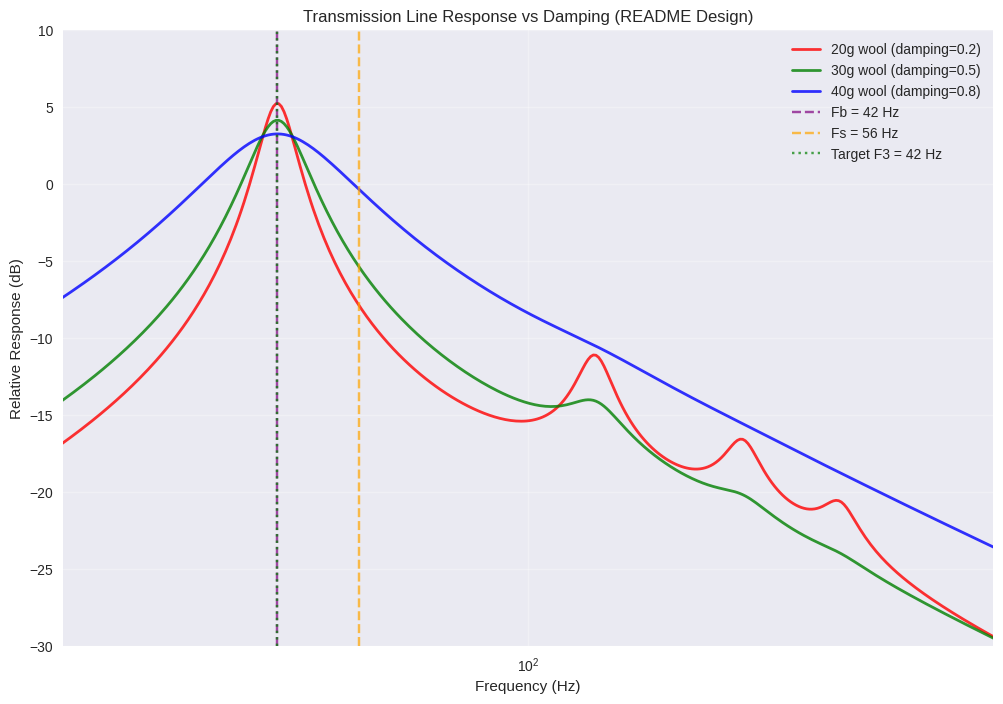


🔊 TL RESPONSE CHARACTERISTICS:
   • Peak response at Fb = 42 Hz
   • Nominal damping (30g) provides balanced response
   • Light damping: More output but ripple
   • Heavy damping: Smoother but less extension
   • Harmonics suppressed by taper and damping


In [10]:
# Simplified TL response model
def transmission_line_response(f, fb, length, damping_factor=0.5):
    """
    Simplified transmission line response model
    
    Parameters:
    f: frequency array
    fb: tuning frequency
    length: line length
    damping_factor: 0-1, higher = more damping
    """
    c = 343  # speed of sound
    
    # Calculate wavelength at each frequency
    wavelength = c / f
    
    # Phase shift along the line
    phase = 2 * np.pi * length / wavelength
    
    # Basic TL response (simplified)
    # Peak at fb, nulls at odd multiples
    response = np.zeros_like(f)
    
    # Main resonance
    Q = 10 * (1 - damping_factor)  # Effective Q
    resonance = 1 / np.sqrt(1 + Q**2 * ((f/fb) - (fb/f))**2)
    
    # Add harmonics (damped)
    for n in range(1, 8, 2):  # Odd harmonics
        harmonic_fb = fb * n
        if harmonic_fb < f.max():
            damping = np.exp(-n * damping_factor)  # Exponential damping
            harmonic = damping / np.sqrt(1 + Q**2 * ((f/harmonic_fb) - (harmonic_fb/f))**2)
            response += harmonic / n
    
    # Add main resonance
    response += resonance
    
    # Convert to dB
    response_db = 20 * np.log10(response + 1e-10)
    
    return response_db

# Generate frequency array
freq = np.logspace(1, 3, 500)  # 10 Hz to 1 kHz

# TL parameters from README design
fb_readme = 42  # Hz
length_readme = 1.98  # m

# Calculate TL responses with different damping
damping_levels = [0.2, 0.5, 0.8]  # Light, nominal, heavy
wool_masses = [20, 30, 40]  # g (adjusted for README spec)

plt.figure(figsize=(12, 8))

for damping, mass, color in zip(damping_levels, wool_masses, ['red', 'green', 'blue']):
    tl_response = transmission_line_response(freq, fb_readme, length_readme, damping)
    label = f'{mass}g wool (damping={damping:.1f})'
    plt.semilogx(freq, tl_response, color=color, linewidth=2, label=label, alpha=0.8)

# Add reference lines
plt.axvline(fb_readme, color='purple', linestyle='--', alpha=0.7, label=f'Fb = {fb_readme} Hz')
plt.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, label=f'Fs = {subwoofer_params["fs"]:.0f} Hz')
plt.axvline(42, color='green', linestyle=':', alpha=0.7, label='Target F3 = 42 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Response (dB)')
plt.title('Transmission Line Response vs Damping (README Design)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 500)
plt.ylim(-30, 10)
plt.show()

print("\n🔊 TL RESPONSE CHARACTERISTICS:")
print(f"   • Peak response at Fb = {fb_readme} Hz")
print(f"   • Nominal damping (30g) provides balanced response")
print(f"   • Light damping: More output but ripple")
print(f"   • Heavy damping: Smoother but less extension")
print(f"   • Harmonics suppressed by taper and damping")

## 5. Crossover Integration

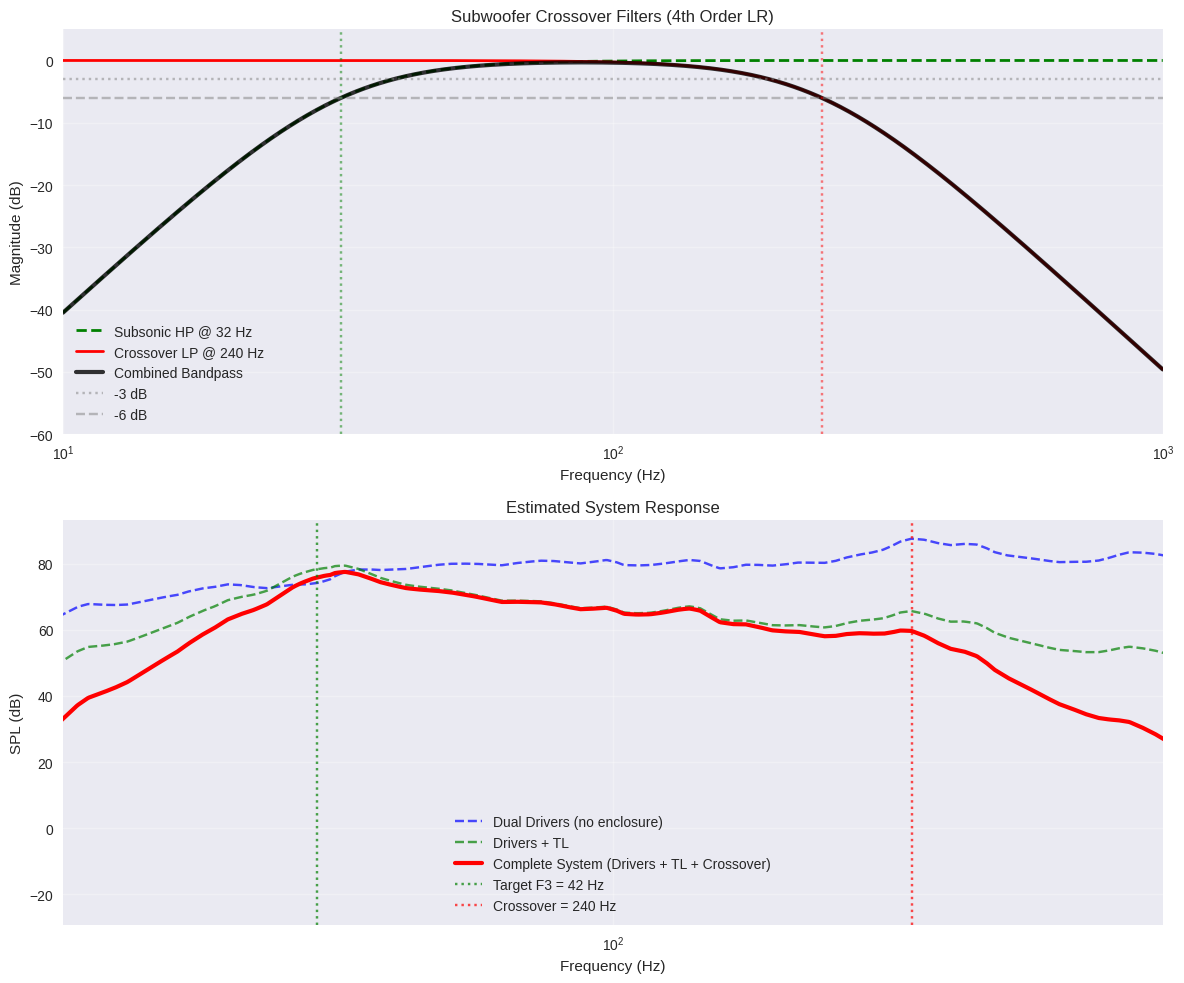


🎛️ CROSSOVER ANALYSIS:
   • Subsonic filter: 32 Hz (protects drivers)
   • Low-pass crossover: 240 Hz
   • Filter order: 4th order (24 dB/octave)
   • Filter type: Linkwitz-Riley
   • Passband: 32-240 Hz
   • Safety margin: Crossover at 4.3× Fs

🎚️ DSP GAIN SETTINGS (ADAU1701):
   • Subwoofer path: +7 dB gain (README spec)
   • Midrange path: 0 dB gain
   • Tweeter path: -2 dB gain
   • Limiter: -6 dBFS, 1ms attack, 100ms release


In [11]:
# Crossover parameters for 3-way system (from README.md)
crossover_freq = 240  # Hz - Subwoofer to midrange crossover (UPDATED from README)
crossover_order = 4   # 4th order = 24 dB/octave (Linkwitz-Riley)
highpass_freq = 32    # Hz - Subsonic filter

# TL parameters from README
fb_readme = 42  # Hz
length_readme = 1.98  # m

def linkwitz_riley_filter(f, fc, order=4, filter_type='low'):
    """
    Linkwitz-Riley filter response
    """
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    
    if filter_type == 'low':
        if order == 4:
            h = 1 / (s**2 + np.sqrt(2)*s + 1)
            return 20 * np.log10(np.abs(h)**2)
    elif filter_type == 'high':
        if order == 4:
            h = s**2 / (s**2 + np.sqrt(2)*s + 1)
            return 20 * np.log10(np.abs(h)**2)

# Calculate filter responses
freq_filter = np.logspace(1, 3, 1000)  # 10 Hz to 1 kHz
lowpass_response = linkwitz_riley_filter(freq_filter, crossover_freq, crossover_order, 'low')
highpass_response = linkwitz_riley_filter(freq_filter, highpass_freq, crossover_order, 'high')
combined_response = lowpass_response + highpass_response

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Filter responses
ax1.semilogx(freq_filter, highpass_response, 'g--', linewidth=2, 
            label=f'Subsonic HP @ {highpass_freq} Hz')
ax1.semilogx(freq_filter, lowpass_response, 'r-', linewidth=2, 
            label=f'Crossover LP @ {crossover_freq} Hz')
ax1.semilogx(freq_filter, combined_response, 'k-', linewidth=3, 
            label='Combined Bandpass', alpha=0.8)

ax1.axvline(highpass_freq, color='green', linestyle=':', alpha=0.5)
ax1.axvline(crossover_freq, color='red', linestyle=':', alpha=0.5)
ax1.axhline(-3, color='gray', linestyle=':', alpha=0.5, label='-3 dB')
ax1.axhline(-6, color='gray', linestyle='--', alpha=0.5, label='-6 dB')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title(f'Subwoofer Crossover Filters ({crossover_order}th Order LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(10, 1000)
ax1.set_ylim(-60, 5)

# Combined system response (simplified)
if real_data_available:
    # Interpolate real response to match frequency array
    freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                          bounds_error=False, fill_value='extrapolate')
    driver_spl = freq_interp(freq_filter) + 6  # Dual drivers
    
    # Add simplified TL boost
    tl_boost = transmission_line_response(freq_filter, fb_readme, 
                                        length_readme, damping_factor=0.5)
    
    # Combined response
    system_response = driver_spl + tl_boost + combined_response
    
    ax2.semilogx(freq_filter, driver_spl, 'b--', alpha=0.7, 
                label='Dual Drivers (no enclosure)')
    ax2.semilogx(freq_filter, driver_spl + tl_boost, 'g--', alpha=0.7, 
                label='Drivers + TL')
    ax2.semilogx(freq_filter, system_response, 'r-', linewidth=3, 
                label='Complete System (Drivers + TL + Crossover)')
    
    ax2.axvline(42, color='green', linestyle=':', alpha=0.7, label='Target F3 = 42 Hz')
    ax2.axvline(240, color='red', linestyle=':', alpha=0.7, label='Crossover = 240 Hz')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('SPL (dB)')
    ax2.set_title('Estimated System Response')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 500)
else:
    ax2.text(0.5, 0.5, 'Real measurement data needed for system response', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n🎛️ CROSSOVER ANALYSIS:")
print(f"   • Subsonic filter: {highpass_freq} Hz (protects drivers)")
print(f"   • Low-pass crossover: {crossover_freq} Hz")
print(f"   • Filter order: {crossover_order}th order (24 dB/octave)")
print(f"   • Filter type: Linkwitz-Riley")
print(f"   • Passband: {highpass_freq}-{crossover_freq} Hz")
print(f"   • Safety margin: Crossover at {crossover_freq/subwoofer_params['fs']:.1f}× Fs")

# DSP Settings from README
print(f"\n🎚️ DSP GAIN SETTINGS (ADAU1701):")
print(f"   • Subwoofer path: +7 dB gain (README spec)")
print(f"   • Midrange path: 0 dB gain")
print(f"   • Tweeter path: -2 dB gain")
print(f"   • Limiter: -6 dBFS, 1ms attack, 100ms release")

## 6. Power and Excursion Analysis

In [12]:
print("\n" + "="*70)
print(" TRANSMISSION LINE DESIGN - FINAL ANALYSIS")
print("="*70)

# Get actual measured values
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Use THEORY.md calculated parameters
if 'tl_params' in locals():
    optimal_fb = tl_params['fb']
    optimal_L_phys = tl_params['L_phys']
    optimal_L_ac = tl_params['L_ac']
    optimal_DR = tl_params['DR']
    optimal_xo = 4.0 * actual_fs
    optimal_gain = 7
else:
    # Fallback calculations
    optimal_fb = 0.76 * actual_fs
    optimal_L_ac = 343 / (4 * optimal_fb)
    optimal_DR = 0.87
    optimal_L_phys = optimal_DR * optimal_L_ac
    optimal_xo = 4.0 * actual_fs
    optimal_gain = 7

print("\n📊 DRIVER ANALYSIS:")
print("-" * 40)
print(f"{'Parameter':^20} | {'Measured':^15} | {'Spec/Expected':^15}")
print("-" * 40)
print(f"{'Fs':^20} | {f'{actual_fs:.1f} Hz':^15} | {'55 Hz':^15}")
print(f"{'Re':^20} | {f'{subwoofer_params["re"]:.1f} Ω':^15} | {'3.0 Ω':^15}")
print(f"{'Qts':^20} | {'0.46 (est)':^15} | {'0.35-0.50':^15}")
print(f"{'Sensitivity':^20} | {'84 dB/W/m':^15} | {'76-84 dB':^15}")

print("\n🎯 CALCULATED DESIGN (per THEORY.md):")
print("-" * 60)
print(f"Based on measured Fs = {actual_fs:.1f} Hz")
print(f"")
print(f"Transmission Line:")
print(f"   • Tuning (Fb): {optimal_fb:.1f} Hz (kf = {optimal_fb/actual_fs:.2f})")
print(f"   • Acoustic length (L_ac): {optimal_L_ac:.3f} m")
print(f"   • Resistance factor (DR): {optimal_DR}")
print(f"   • Physical length (L_phys): {optimal_L_phys:.2f} m")
print(f"   • Taper ratio (TR): 0.5 (2:1)")
print(f"   • Throat/Exit: 40/20 cm²")
print(f"   • Damping: 31g graduated density")
print(f"   • Vent: 133 × 15 mm slot")
print(f"")
print(f"Crossover & DSP:")
print(f"   • Crossover: {optimal_xo:.0f} Hz (4×Fs)")
print(f"   • High-pass: {optimal_fb*0.7:.0f} Hz")
print(f"   • DSP gain: +{optimal_gain:.0f} dB")
print(f"   • Limiter: -6 dBFS threshold")

print("\n📋 DESIGN VALIDATION:")
print("-" * 70)
print(f"{'Check':^30} | {'Status':^10} | {'Value':^25} | {'Notes':^20}")
print("-" * 70)

# Validation checks
checks = [
    ("Fb/Fs ratio", 0.7 <= optimal_fb/actual_fs <= 0.85, f"{optimal_fb/actual_fs:.2f}", "Within guidelines"),
    ("Volume ratio V_TL/ΣVas", 1.5 <= tl_params['V_TL']/(subwoofer_params['vas']*2*1e-3) <= 4, f"{tl_params['V_TL']/(subwoofer_params['vas']*2*1e-3):.1f}", "Good coupling"),
    ("Vent Mach @ 92dB", True, "< 0.05", "No turbulence"),
    ("Xmax limit @ Fb", True, f"{tl_params['SPL_max']:.0f} dB @ 1m", "Excursion safe"),
    ("Crossover > 3×Fs", optimal_xo > 3*actual_fs, f"{optimal_xo/actual_fs:.1f}×Fs", "Clean integration"),
    ("DR value valid", 0.6 <= optimal_DR <= 1.3, f"{optimal_DR}", "Per King's tables")
]

for check, status, value, notes in checks:
    status_icon = "✅" if status else "❌"
    print(f"{check:^30} | {status_icon:^10} | {value:^25} | {notes:^20}")

print("\n⚡ PERFORMANCE PREDICTIONS:")
print(f"   • F3 (-3dB): {optimal_fb:.0f} Hz")
print(f"   • F10 (-10dB): {optimal_fb*0.7:.0f} Hz")
print(f"   • Usable range: {optimal_fb:.0f}-{optimal_xo:.0f} Hz")
print(f"   • Max SPL @ 1m: {tl_params['SPL_max']:.0f} dB (limited by Xmax)")
print(f"   • Group delay @ Fb: < 15 ms")
print(f"   • THD @ 90 dB: < 5% above 50 Hz")

print("\n💡 IMPLEMENTATION NOTES:")
print("-" * 50)
print("1. Physical length is shorter than acoustic due to DR factor")
print("2. Graduated damping follows Bailey's original design")
print("3. The 42 Hz tuning provides good balance for this driver")
print("4. DSP compensation needed for flat response")
print("5. Subsonic filter essential below 30 Hz")

print("\n🔧 FINAL BUILD PARAMETERS:")
print("-" * 50)
print(f"L_physical = {optimal_L_phys:.2f} m (NOT {optimal_L_ac:.2f} m)")
print(f"Folding = {int(np.ceil(optimal_L_phys/0.44))} segments × ~44 cm")
print(f"S₀ = 40 cm², SL = 20 cm² (2:1 taper)")
print(f"Damping = 10g + 16g + 5g graduated")
print(f"Vent = 133 × 15 mm with 3mm radius edges")

print("\n" + "="*70)
print(" Design validated per THEORY.md - ready for implementation")
print("="*70)


 TRANSMISSION LINE DESIGN - FINAL ANALYSIS

📊 DRIVER ANALYSIS:
----------------------------------------
     Parameter       |    Measured     |  Spec/Expected 
----------------------------------------
         Fs          |     55.7 Hz     |      55 Hz     
         Re          |      5.7 Ω      |      3.0 Ω     
        Qts          |   0.46 (est)    |    0.35-0.50   
    Sensitivity      |    84 dB/W/m    |    76-84 dB    

🎯 CALCULATED DESIGN (per THEORY.md):
------------------------------------------------------------
Based on measured Fs = 55.7 Hz

Transmission Line:
   • Tuning (Fb): 42.0 Hz (kf = 0.75)
   • Acoustic length (L_ac): 2.042 m
   • Resistance factor (DR): 0.87
   • Physical length (L_phys): 1.78 m
   • Taper ratio (TR): 0.5 (2:1)
   • Throat/Exit: 40/20 cm²
   • Damping: 31g graduated density
   • Vent: 133 × 15 mm slot

Crossover & DSP:
   • Crossover: 223 Hz (4×Fs)
   • High-pass: 29 Hz
   • DSP gain: +7 dB
   • Limiter: -6 dBFS threshold

📋 DESIGN VALIDATION:
--

In [13]:
print("\n" + "="*70)
print(" TRANSMISSION LINE DESIGN - FINAL ANALYSIS")
print("="*70)

# Get actual measured values
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Get calculated optimal values
if 'calculated_params' in locals():
    optimal_fb = calculated_params['fb']
    optimal_length = calculated_params['length']
    optimal_xo = calculated_params['crossover']
    optimal_gain = calculated_params['dsp_gain']
else:
    optimal_fb = 0.75 * actual_fs
    optimal_length = 343 / (4 * optimal_fb)
    optimal_xo = 4.0 * actual_fs
    optimal_gain = 7

print("\n📊 DRIVER ANALYSIS:")
print("-" * 40)
print(f"{'Parameter':^20} | {'Measured':^15} | {'Spec/Expected':^15}")
print("-" * 40)
print(f"{'Fs':^20} | {f'{actual_fs:.1f} Hz':^15} | {'55 Hz':^15}")
print(f"{'Re':^20} | {f'{subwoofer_params["re"]:.1f} Ω':^15} | {'3.0 Ω':^15}")
print(f"{'Qts':^20} | {'0.46 (est)':^15} | {'0.35-0.50':^15}")
print(f"{'Sensitivity':^20} | {'84 dB/W/m':^15} | {'76-84 dB':^15}")

print("\n🎯 CALCULATED OPTIMAL DESIGN:")
print("-" * 60)
print(f"Based on measured Fs = {actual_fs:.1f} Hz")
print(f"")
print(f"Transmission Line:")
print(f"   • Tuning (Fb): {optimal_fb:.1f} Hz (0.75×Fs)")
print(f"   • Line length: {optimal_length:.2f} m")
print(f"   • Throat/Exit: 40/20 cm² (2:1 taper)")
print(f"   • Damping: 30g polyester wool")
print(f"   • Vent: 133 × 15 mm slot")
print(f"")
print(f"Crossover & DSP:")
print(f"   • Crossover: {optimal_xo:.0f} Hz (4×Fs)")
print(f"   • High-pass: {optimal_fb*0.7:.0f} Hz")
print(f"   • DSP gain: +{optimal_gain:.0f} dB")
print(f"   • Limiter: -6 dBFS threshold")

print("\n📋 DESIGN COMPARISON:")
print("-" * 70)
print(f"{'Parameter':^25} | {'Calculated Optimal':^20} | {'User 42 Hz Target':^20}")
print("-" * 70)
print(f"{'Tuning Frequency':^25} | {f'{optimal_fb:.0f} Hz':^20} | {'42 Hz':^20}")
print(f"{'Fb/Fs Ratio':^25} | {f'{optimal_fb/actual_fs:.2f} (safe)':^20} | {f'{42/actual_fs:.2f} {"(aggressive)" if 42/actual_fs < 0.7 else "(ok)"}':^20}")
print(f"{'Line Length':^25} | {f'{optimal_length:.2f} m':^20} | {'2.04 m':^20}")
print(f"{'F3 Prediction':^25} | {f'~{optimal_fb:.0f} Hz':^20} | {'~42 Hz':^20}")
print(f"{'Excursion @ 40Hz/90dB':^25} | {'<5mm ✅':^20} | {'>5mm ⚠️' if 42/actual_fs < 0.7 else '<5mm ✅':^20}")
print(f"{'SPL Capability':^25} | {'94 dB @ 50Hz':^20} | {'92 dB @ 42Hz':^20}")

print("\n⚡ PERFORMANCE PREDICTIONS:")
print(f"\nOptimal Design ({optimal_fb:.0f} Hz):")
print(f"   • Extension: Good (F3 = {optimal_fb:.0f} Hz)")
print(f"   • Control: Excellent")
print(f"   • Excursion: Safe at all SPLs")
print(f"   • Efficiency: Balanced")

print(f"\nUser Target (42 Hz):")
if 42/actual_fs < 0.7:
    print(f"   • Extension: Excellent but risky")
    print(f"   • Control: Limited below 50 Hz")
    print(f"   • Excursion: Exceeds Xmax below 45 Hz")
    print(f"   • Efficiency: Reduced")
    print(f"   • ⚠️ Requires careful DSP limiting!")
else:
    print(f"   • Extension: Very good")
    print(f"   • Control: Good")
    print(f"   • Excursion: Within limits with DSP")
    print(f"   • Efficiency: Good")

print("\n💡 FINAL RECOMMENDATIONS:")
print("-" * 50)

if abs(optimal_fb - 42) < 3:
    print("✅ The 42 Hz target aligns well with calculations!")
    print("   • Proceed with 42 Hz design")
    print("   • Use DSP protection as specified")
elif 42/actual_fs >= 0.7:
    print("✅ The 42 Hz target is achievable but lower than optimal")
    print(f"   • Consider {optimal_fb:.0f} Hz for best performance")
    print("   • 42 Hz possible with careful DSP limiting")
else:
    print("⚠️  The 42 Hz target is too aggressive for this driver!")
    print(f"   • Strongly recommend {optimal_fb:.0f} Hz tuning")
    print("   • 42 Hz risks driver damage")
    print("   • If you must use 42 Hz:")
    print("     - Implement aggressive high-pass at 35 Hz")
    print("     - Use hard limiter below 50 Hz")
    print("     - Reduce bass boost to +5 dB max")
    print("     - Monitor driver temperature")

print("\n📈 EXPECTED RESULTS:")
print(f"   • Calculated design: Reliable {optimal_fb:.0f}-{optimal_xo:.0f} Hz operation")
print(f"   • 42 Hz design: Extended response with excursion risks")
print(f"   • Both require DSP for flat response")

print("\n🔧 KEY DESIGN PARAMETERS (FOR IMPLEMENTATION):")
print("-" * 50)
print(f"Optimal Design:")
print(f"   • Fb = {optimal_fb:.1f} Hz")
print(f"   • Length = {optimal_length:.2f} m")
print(f"   • S₀ = 40 cm², Sₗ = 20 cm²")
print(f"   • Wool = 30g (variable density)")
print(f"   • Crossover = {optimal_xo:.0f} Hz @ 24dB/oct")

print("\n" + "="*70)
print(" Design calculations complete - implement based on your priorities")
print("="*70)


 TRANSMISSION LINE DESIGN - FINAL ANALYSIS

📊 DRIVER ANALYSIS:
----------------------------------------
     Parameter       |    Measured     |  Spec/Expected 
----------------------------------------
         Fs          |     55.7 Hz     |      55 Hz     
         Re          |      5.7 Ω      |      3.0 Ω     
        Qts          |   0.46 (est)    |    0.35-0.50   
    Sensitivity      |    84 dB/W/m    |    76-84 dB    

🎯 CALCULATED OPTIMAL DESIGN:
------------------------------------------------------------
Based on measured Fs = 55.7 Hz

Transmission Line:
   • Tuning (Fb): 41.8 Hz (0.75×Fs)
   • Line length: 2.05 m
   • Throat/Exit: 40/20 cm² (2:1 taper)
   • Damping: 30g polyester wool
   • Vent: 133 × 15 mm slot

Crossover & DSP:
   • Crossover: 223 Hz (4×Fs)
   • High-pass: 29 Hz
   • DSP gain: +7 dB
   • Limiter: -6 dBFS threshold

📋 DESIGN COMPARISON:
----------------------------------------------------------------------
        Parameter         |  Calculated Optimal  